In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define MNIST model architecture
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# Load MNIST data
transform = transforms.ToTensor()
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transform)


In [4]:
# Train the model
def train_model(model, train_loader, optimizer, epochs=5):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

In [5]:
# Evaluate the model for loss and accuracy
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return loss / len(loader), accuracy


In [6]:
# Calculate sensitivity as the gradient norm
def calculate_sensitivity(model, data):
    model.eval()
    data.requires_grad = True
    output = model(data)
    target = output.max(1)[1]
    loss = nn.CrossEntropyLoss()(output, target)
    loss.backward()
    sensitivity = data.grad.norm().item()  # Gradient norm as sensitivity measure
    return sensitivity


In [7]:
# Experiment with different batch sizes
batch_sizes = [32, 64, 128, 256, 512]
results = []

# Train and evaluate models with different batch sizes
for batch_size in batch_sizes:
    print(f'Training model with batch size {batch_size}')
    
    # Create model and optimizer
    mnist_model = MNISTModel()
    optimizer_mnist = optim.Adam(mnist_model.parameters(), lr=1e-3)
    
    # Create data loaders
    train_loader_mnist = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    test_loader_mnist = torch.utils.data.DataLoader(mnist_test, batch_size=1000, shuffle=False)
    
    # Train the model
    train_model(mnist_model, train_loader_mnist, optimizer_mnist, epochs=5)
    
    # Evaluate the model
    train_loss, train_acc = evaluate_model(mnist_model, train_loader_mnist)
    test_loss, test_acc = evaluate_model(mnist_model, test_loader_mnist)
    
    # Calculate sensitivity using a sample from the training loader
    sensitivity_mnist = calculate_sensitivity(mnist_model, next(iter(train_loader_mnist))[0])
    
    # Save the results
    results.append((train_loss, test_loss, train_acc, test_acc, sensitivity_mnist))


Training model with batch size 32
Training model with batch size 64
Training model with batch size 128
Training model with batch size 256
Training model with batch size 512


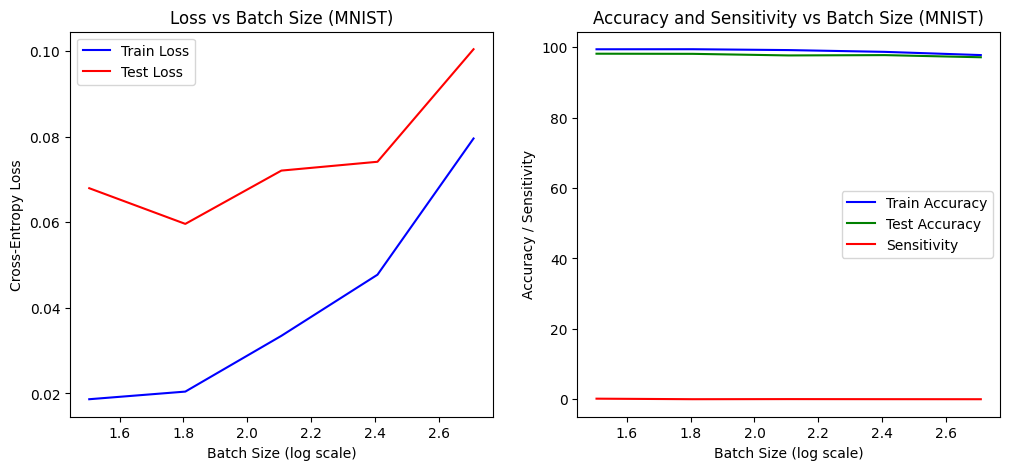

In [8]:
# Plotting the results
def plot_results(results):
    batch_sizes_log = np.log10(batch_sizes)
    train_loss = [r[0] for r in results]
    test_loss = [r[1] for r in results]
    train_acc = [r[2] for r in results]
    test_acc = [r[3] for r in results]
    sensitivity = [r[4] for r in results]
    
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(batch_sizes_log, train_loss, label='Train Loss', color='blue')
    plt.plot(batch_sizes_log, test_loss, label='Test Loss', color='red')
    plt.xlabel('Batch Size (log scale)')
    plt.ylabel('Cross-Entropy Loss')
    plt.title('Loss vs Batch Size (MNIST)')
    plt.legend()
    
    # Plot Accuracy and Sensitivity
    plt.subplot(1, 2, 2)
    plt.plot(batch_sizes_log, train_acc, label='Train Accuracy', color='blue')
    plt.plot(batch_sizes_log, test_acc, label='Test Accuracy', color='green')
    plt.plot(batch_sizes_log, sensitivity, label='Sensitivity', color='red')
    plt.xlabel('Batch Size (log scale)')
    plt.ylabel('Accuracy / Sensitivity')
    plt.title('Accuracy and Sensitivity vs Batch Size (MNIST)')
    plt.legend()
    
    plt.show()

# Plot results for MNIST
plot_results(results)